This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

In [3]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,-0.579435,1.109071,-0.039398,0,1
1,0.564281,0.724424,0.369388,0,0
2,-0.748874,-0.044869,-1.347515,0,0
3,-0.935257,-0.814163,-1.511030,0,0
4,-0.164308,-0.429516,1.186962,1,0
...,...,...,...,...,...
197751,-0.092296,1.109071,-0.448185,0,0
197752,-0.854774,1.109071,-0.611699,0,1
197753,0.521921,1.777461,0.063806,0,0
197754,-0.981853,0.724424,-0.448185,0,1


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [4]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['incwage', 'years_of_educ', 'potential_experience']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']], y=train_data.loc[:,"non_white"])
    
    node_indicators = cart_non_white.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [train_data['non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [5]:
best_objective, full_sXs, GMM = -10, 1, 1

def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_non_white_, mb_sex_):

        pmse_ratios, current_sXs, current_GMM = train_models(train_data=train_data,
                                                             number_synthetic_datasets=number_synthetic_datasets,
                                                             number_gmm_initializations=number_gmm_initializations,
                                                             num_components_=int(num_components_),
                                                             mb_non_white_=int(mb_non_white_),
                                                             mb_sex_=int(mb_sex_))
        
        global best_objective

        current_objective = -1 * ((1 - np.mean(pmse_ratios))**2)

        if current_objective > best_objective:

            global full_sXs

            global GMM

            best_objective = current_objective
            full_sXs = current_sXs
            GMM = current_GMM

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_non_white_": (10, 300.99),
            "mb_sex_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | mb_non... |  mb_sex_  | num_co... |
-------------------------------------------------------------
| 1         | -0.0133   | 226.2     | 75.89     | 132.7     |
| 2         | -0.5037   | 266.8     | 225.5     | 147.8     |
| 3         | -226.7    | 95.94     | 162.9     | 43.19     |
| 4         | -231.0    | 246.3     | 257.2     | 58.99     |
| 5         | -6.616    | 79.03     | 143.4     | 53.72     |
| 6         | -0.3243   | 266.6     | 225.9     | 148.5     |
| 7         | -15.39    | 69.79     | 132.7     | 59.48     |
| 8         | -0.01632  | 231.6     | 95.5      | 135.5     |
| 9         | -0.2636   | 241.0     | 80.16     | 149.9     |
| 10        | -0.08041  | 250.0     | 81.01     | 126.3     |
| 11        | -0.002826 | 261.1     | 102.9     | 143.8     |
| 12        | -0.000247 | 254.5     | 112.4     | 115.3     |
| 13        | -0.01886  | 230.2     | 93.44     | 100.7     |
| 14        | -0.8352   | 262.3     | 90.16     | 90.57     |
| 15    

***

In [8]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

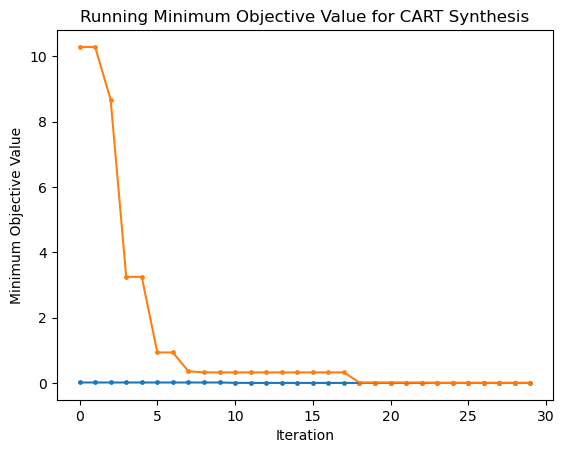

In [9]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -0.000247158793207409,
 'params': {'mb_non_white_': 254.45158451959364,
  'mb_sex_': 112.3939802343799,
  'num_components_': 115.30828599655548}}

***

Generate 20 synthetic datasets.

In [27]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_non_white_=int(best_params['params']['mb_non_white_']))

In [28]:
np.mean(pmse_ratios)

0.9605744153660106

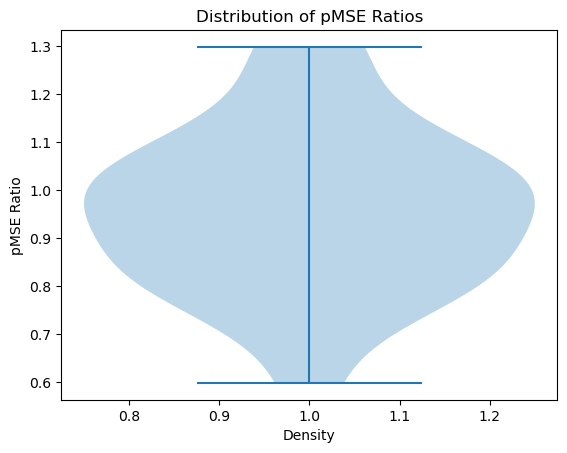

In [29]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [30]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

In [35]:
import pickle

# save
with open('../Results/IPUMS/Models/gmm_and_cart.pkl','wb') as f:
    pickle.dump(GMM,f)

In [36]:
# load
with open('../Results/IPUMS/Models/gmm_and_cart.pkl', 'rb') as f:
    GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [32]:
prior = np.mean(train_data.non_white == 1)

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [33]:
c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [34]:
deltas = np.linspace(0.001, 1, 5)

In [49]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                         categorical_vars=['sex'],
                                         sensitive_var='non_white',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

Record 49439 completed.
Record 98878 completed.
Stuck in inference loop.
Stuck in inference loop.
Stuck in inference loop.
Stuck in inference loop.
Stuck in inference loop.
Record 148317 completed.
Full anonymization loop 1 completed.
Record 49439 completed.
Record 98878 completed.
Record 148317 completed.
Full anonymization loop 2 completed.
Record 49439 completed.
Record 98878 completed.
Record 148317 completed.
Full anonymization loop 3 completed.
Record 49439 completed.
Record 98878 completed.
Record 148317 completed.
Full anonymization loop 4 completed.
Record 49439 completed.
Record 98878 completed.
Record 148317 completed.


KeyboardInterrupt: 

In [ ]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)

***